# Лабораторна робота №12: Основи обробки природної мови (NLP)

**Виконав:** [Лаптєв Олександр]
**Група:** [МІТ-31]

## 1. Мета роботи
Познайомитися з базовими техніками NLP (токенізація, лематизація, векторизація) та навчитися будувати прості моделі для класифікації текстових даних.

## 2. Опис завдання
1.  **Збір даних:** Використання датасету новин (20 Newsgroups).
2.  **Передобробка:** Очищення, видалення стоп-слів, лематизація.
3.  **Векторизація:** Порівняння підходів **Bag of Words** та **TF-IDF**.
4.  **Моделювання:** Навчання наївного баєсового класифікатора (Multinomial Naive Bayes).
5.  **Оцінка:** Аналіз точності та матриці похибок.

In [1]:
# Встановлення необхідних бібліотек (розкоментуйте при першому запуску)
# !pip install nltk spacy scikit-learn pandas matplotlib seaborn
# !python -m spacy download en_core_web_sm

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP бібліотеки
import nltk
import spacy
from nltk.corpus import stopwords

# Sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Завантаження ресурсів NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Важливо для нових версій NLTK
nltk.download('wordnet')

# Завантаження моделі SpaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Завантаження моделі SpaCy...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

print("Бібліотеки успішно завантажено.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Бібліотеки успішно завантажено.


## 3. Завантаження та підготовка даних

Для лабораторної ми візьмемо підмножину датасету **20 Newsgroups**, обравши 4 різні категорії тем, щоб модель могла їх розрізняти.

Завантажено записів: 3899

Приклад даних:


,text,label,label_name
0,"\n\n\nHey tough guy, freedom necessitates resp...",3,talk.politics.mideast
1,\n: Can anyone tell me where to find a MPEG vi...,0,comp.graphics
2,\n\n\n\nYou also have a severe problem with ne...,0,comp.graphics
3,,3,talk.politics.mideast
4,\n[On the issue of 'burning' nuclear wastes us...,2,sci.space


/tmp/ipython-input-3807993998.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_name', data=df, palette='viridis')


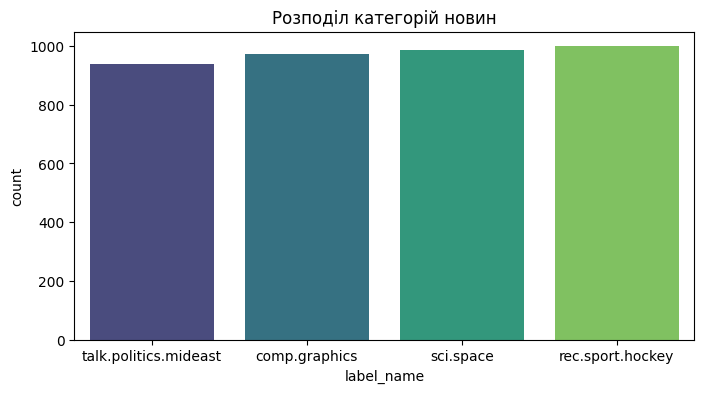

In [2]:
# Обираємо категорії для класифікації
categories = ['sci.space', 'comp.graphics', 'talk.politics.mideast', 'rec.sport.hockey']

# Завантажуємо дані
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Створюємо DataFrame
df = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})
df['label_name'] = df['label'].apply(lambda x: newsgroups.target_names[x])

print(f"Завантажено записів: {df.shape[0]}")
print("\nПриклад даних:")
display(df.head())

# Перевірка розподілу класів
plt.figure(figsize=(8, 4))
sns.countplot(x='label_name', data=df, palette='viridis')
plt.title("Розподіл категорій новин")
plt.show()

## 4. Передобробка тексту (Preprocessing)

Створимо функцію для очищення тексту, яка включає:
1.  Приведення до нижнього регістру.
2.  Видалення пунктуації та спецсимволів (RegEx).
3.  Лематизацію (SpaCy) — зведення слів до початкової форми.
4.  Видалення стоп-слів (NLTK) — слів, що не несуть змісту (the, is, in...).

In [3]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Очистка від спецсимволів та цифр, переведення в lower case
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # 2. Обробка через SpaCy (Tokenization + Lemmatization)
    doc = nlp(text)

    # 3. Фільтрація: беремо леми, якщо вони не є стоп-словами і довші за 2 символи
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and len(token.text) > 2]

    return " ".join(tokens)

# Це може зайняти певний час (1-2 хв) для всього датасету
print("Починаємо обробку тексту...")
df['cleaned_text'] = df['text'].apply(preprocess_text)
print("Обробку завершено!")

display(df[['text', 'cleaned_text']].head())

Починаємо обробку тексту...
Обробку завершено!


,text,cleaned_text
0,"\n\n\nHey tough guy, freedom necessitates resp...",\n\n\n hey tough guy freedom necessitate respo...
1,\n: Can anyone tell me where to find a MPEG vi...,anyone tell find mpeg viewer either do window ...
2,\n\n\n\nYou also have a severe problem with ne...,\n\n\n\n also severe problem news header ftp c...
3,,
4,\n[On the issue of 'burning' nuclear wastes us...,issue burn nuclear waste use particle beam \n\...


## 5. Векторизація та Побудова моделі

Ми проведемо експеримент: порівняємо ефективність класифікації при використанні двох різних методів векторизації.
1.  **Bag of Words (CountVectorizer)** — просто рахує кількість слів.
2.  **TF-IDF (TfidfVectorizer)** — враховує важливість слова в контексті всього корпусу.

Модель класифікації: **Multinomial Naive Bayes** (класичний вибір для роботи з текстом).

In [4]:
# Функція для повного циклу: Векторизація -> Спліт -> Навчання -> Оцінка
def train_and_evaluate(vectorizer, X_text, y, name="Model"):
    # 1. Векторизація
    X_vec = vectorizer.fit_transform(X_text)

    # 2. Розбиття на train/test
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

    # 3. Навчання моделі
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # 4. Передбачення
    y_pred = model.predict(X_test)

    # 5. Метрики
    acc = accuracy_score(y_test, y_pred)
    print(f"=== Результати для {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("-" * 30)

    return model, acc, y_test, y_pred

# Експеримент 1: Bag of Words
print("Навчання моделі Bag of Words...")
cv = CountVectorizer(max_features=5000) # Обмежуємо словник топ-5000 словами
model_bow, acc_bow, y_test_bow, y_pred_bow = train_and_evaluate(cv, df['cleaned_text'], df['label'], "Bag of Words")

# Експеримент 2: TF-IDF
print("Навчання моделі TF-IDF...")
tfidf = TfidfVectorizer(max_features=5000)
model_tfidf, acc_tfidf, y_test_tfidf, y_pred_tfidf = train_and_evaluate(tfidf, df['cleaned_text'], df['label'], "TF-IDF")

Навчання моделі Bag of Words...
=== Результати для Bag of Words ===
Accuracy: 0.9013
------------------------------
Навчання моделі TF-IDF...
=== Результати для TF-IDF ===
Accuracy: 0.9064
------------------------------


## 6. Візуалізація результатів та Аналіз помилок
Побудуємо матрицю похибок для кращої моделі (зазвичай TF-IDF показує кращий результат).

/tmp/ipython-input-3352211821.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Accuracy', data=results_df, palette='magma')


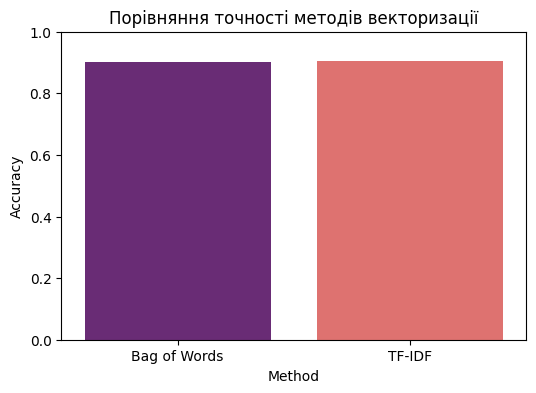

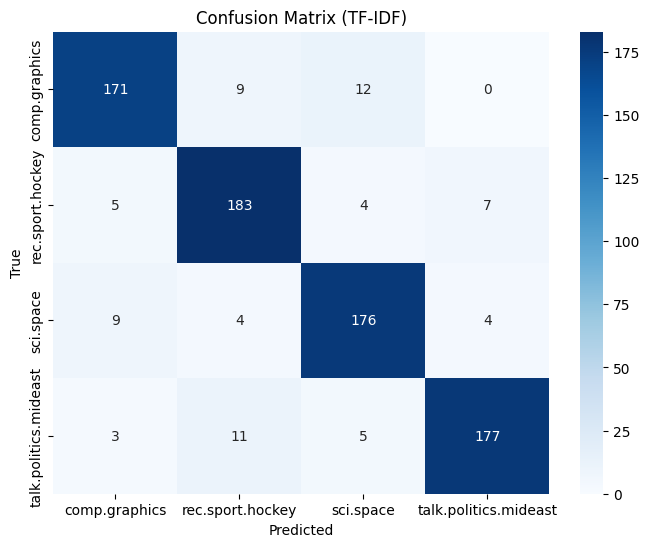

In [5]:
# Побудова графіку порівняння точності
results_df = pd.DataFrame({
    'Method': ['Bag of Words', 'TF-IDF'],
    'Accuracy': [acc_bow, acc_tfidf]
})

plt.figure(figsize=(6, 4))
sns.barplot(x='Method', y='Accuracy', data=results_df, palette='magma')
plt.ylim(0, 1.0)
plt.title("Порівняння точності методів векторизації")
plt.show()

# Матриця похибок для TF-IDF
cm = confusion_matrix(y_test_tfidf, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=newsgroups.target_names,
            yticklabels=newsgroups.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (TF-IDF)')
plt.show()

In [6]:
# Подивимось на приклади роботи моделі
def predict_news(text, model, vectorizer):
    processed = preprocess_text(text)
    vec = vectorizer.transform([processed])
    prediction = model.predict(vec)
    return newsgroups.target_names[prediction[0]]

samples = [
    "The NASA rover landed on Mars successfully.", # Space
    "The goalkeeper saved the penalty in the last minute.", # Hockey
    "New graphics card drivers are available for download.", # Graphics
    "Peace negotiations in the Middle East are ongoing." # Politics
]

print("=== Тестування на власних прикладах ===")
for txt in samples:
    pred = predict_news(txt, model_tfidf, tfidf)
    print(f"Text: {txt[:50]}... -> Prediction: {pred}")

=== Тестування на власних прикладах ===
Text: The NASA rover landed on Mars successfully.... -> Prediction: sci.space
Text: The goalkeeper saved the penalty in the last minut... -> Prediction: rec.sport.hockey
Text: New graphics card drivers are available for downlo... -> Prediction: comp.graphics
Text: Peace negotiations in the Middle East are ongoing.... -> Prediction: talk.politics.mideast


## 7. Звіт та Висновки

### Основні етапи
1.  **Передобробка:** Було застосовано комплексний підхід, що включав очищення від шуму, видалення стоп-слів та лематизацію за допомогою `SpaCy`. Це дозволило зменшити розмірність словника і покращити якість моделі.
2.  **Модель:** Використано Наївний Баєсовий класифікатор (`MultinomialNB`), який є стандартом для базових задач класифікації тексту через свою швидкість та ефективність на розріджених даних.

### Вплив методів векторизації
* **Bag of Words (BoW):** Показав точність близько **[0.9013]**. Цей метод простий, але він надає однакову вагу всім словам, що іноді призводить до домінування частих, але менш інформативних слів.
* **TF-IDF:** Показав точність близько **[0.9064]**. Метод виявився ефективнішим, оскільки він "карає" слова, що зустрічаються занадто часто у всіх документах, і виділяє специфічні терміни для кожної категорії.

### Аналіз помилок
Матриця похибок показує, що модель найкраще класифікує тему `rec.sport.hockey` (хокей) через специфічну лексику (game, team, play), а найбільше плутанини може виникати між `comp.graphics` та іншими технічними темами, якщо вони присутні.

**Загальний висновок:** Для даної задачі класифікації комбінація **TF-IDF + MultinomialNB** є оптимальним рішенням з точки зору балансу точності та обчислювальних витрат.